# Capstone Three 

## Project Introduction

### Purpose
The primary aim of this project is to explore and understand healthcare interactions within a network focused on stroke-related healthcare. We seek to identify key nodes and connections that could potentially enhance the efficiency and effectiveness of stroke prevention and management strategies.

### Dataset Description
This analysis utilizes a comprehensive stroke dataset that contains various health-related attributes of individuals, which are critical in predicting stroke occurrences. Key features include demographic, health status, and lifestyle factors, which are used to construct a network of healthcare interactions and apply predictive modeling to improve healthcare outcomes.

### Key Variables
- **id**: Unique identifier for each patient.
- **gender**: Gender of the patient (Male, Female, Other).
- **age**: Age of the patient.
- **hypertension**: Indicates the presence of hypertension (0 = no, 1 = yes).
- **heart_disease**: Indicates the presence of heart disease (0 = no, 1 = yes).
- **ever_married**: Marital status (Yes, No).
- **work_type**: Type of employment (children, Govt_job, Never_worked, Private, Self-employed).
- **Residence_type**: Living area (Rural, Urban).
- **avg_glucose_level**: Average glucose level in blood.
- **bmi**: Body Mass Index.
- **smoking_status**: Smoking habits (formerly smoked, never smoked, smokes, Unknown).
- **stroke**: Indicates if the patient had a stroke (0 = no, 1 = yes).


In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Load the dataset
file_path = 'healthcare-dataset-stroke-data.csv'
stroke_data = pd.read_csv(file_path)

# Display the first few rows and check for missing values and data types
initial_overview = stroke_data.head()
data_types = stroke_data.dtypes
missing_values = stroke_data.isnull().sum()
statistical_summary = stroke_data.describe()

(initial_overview, data_types, missing_values, statistical_summary)

(      id  gender   age  hypertension  heart_disease ever_married  \
 0   9046    Male  67.0             0              1          Yes   
 1  51676  Female  61.0             0              0          Yes   
 2  31112    Male  80.0             0              1          Yes   
 3  60182  Female  49.0             0              0          Yes   
 4   1665  Female  79.0             1              0          Yes   
 
        work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
 0        Private          Urban             228.69  36.6  formerly smoked   
 1  Self-employed          Rural             202.21   NaN     never smoked   
 2        Private          Rural             105.92  32.5     never smoked   
 3        Private          Urban             171.23  34.4           smokes   
 4  Self-employed          Rural             174.12  24.0     never smoked   
 
    stroke  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
 id                     int64
 gend

## Initial Data Overview

The dataset contains the following columns, with a snapshot of the first few entries:

- **id:** Unique identifier for each patient.
- **gender:** Gender of the patient (Male, Female, Other).
- **age:** Age of the patient.
- **hypertension:** Indicates the presence of hypertension (0 = no, 1 = yes).
- **heart_disease:** Indicates the presence of heart disease (0 = no, 1 = yes).
- **ever_married:** Marital status (Yes, No).
- **work_type:** Type of employment (children, Govt_job, Never_worked, Private, Self-employed).
- **Residence_type:** Living area (Rural, Urban).
- **avg_glucose_level:** Average glucose level.
- **bmi:** Body Mass Index.
- **smoking_status:** Smoking habits (formerly smoked, never smoked, smokes, Unknown).
- **stroke:** Indicates if the patient had a stroke (0 = no, 1 = yes).

### Data Types and Missing Values

The dataset primarily consists of numerical and categorical data. Key columns like age, avg_glucose_level, and bmi are numerical, while others like gender and smoking_status are categorical.

There are 201 missing values in the bmi column, which we'll need to address, either by imputation or removal.

### Statistical Summary

- The age ranges from about 0.08 years (likely indicating infants) to 82 years.
- Average glucose levels and BMI indicate a wide range of values, typical of a diverse dataset including both healthy individuals and those with medical conditions.
- Most patients do not have hypertension or heart disease, as indicated by the averages close to 0.

## Next Steps

- **Handling Missing Values:** We need to decide how to handle the missing values in the bmi column. Options include imputation based on median/mean values or more complex strategies like predictive modeling.
- **Categorization:** For network analysis, we can categorize continuous variables like age and avg_glucose_level into groups (e.g., age groups).
- **Data Cleaning:** Convert categorical data into a format suitable for analysis, check for any anomalies or outliers, and perform type conversions if necessary.


In [5]:
# Handling Missing Values: Impute the missing values in 'bmi' with the median value of the column
bmi_median = stroke_data['bmi'].median()
stroke_data['bmi'].fillna(bmi_median, inplace=True)

# Categorizing 'age'
age_bins = [0, 12, 19, 59, 120]  # The upper limit of 120 accounts for all ages above 59
age_labels = ['Child', 'Teen', 'Adult', 'Senior']
stroke_data['age_category'] = pd.cut(stroke_data['age'], bins=age_bins, labels=age_labels, right=False)

# Categorizing 'avg_glucose_level'
glucose_bins = [0, 100, 126, float('inf')]  # Using float('inf') to include all higher values
glucose_labels = ['Normal', 'Pre-diabetic', 'Diabetic']
stroke_data['glucose_category'] = pd.cut(stroke_data['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels, right=False)

# Convert categorical variables to 'category' data type
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_category', 'glucose_category']
stroke_data[categorical_cols] = stroke_data[categorical_cols].astype('category')

# Check the changes
updated_info = {
    "Data Types": stroke_data.dtypes,
    "Missing Values": stroke_data.isnull().sum(),
    "Sample Data": stroke_data.head()
}

updated_info


{'Data Types': id                      int64
 gender               category
 age                   float64
 hypertension            int64
 heart_disease           int64
 ever_married         category
 work_type            category
 Residence_type       category
 avg_glucose_level     float64
 bmi                   float64
 smoking_status       category
 stroke                  int64
 age_category         category
 glucose_category     category
 dtype: object,
 'Missing Values': id                   0
 gender               0
 age                  0
 hypertension         0
 heart_disease        0
 ever_married         0
 work_type            0
 Residence_type       0
 avg_glucose_level    0
 bmi                  0
 smoking_status       0
 stroke               0
 age_category         0
 glucose_category     0
 dtype: int64,
 'Sample Data':       id  gender   age  hypertension  heart_disease ever_married  \
 0   9046    Male  67.0             0              1          Yes   
 1  51676  Fem

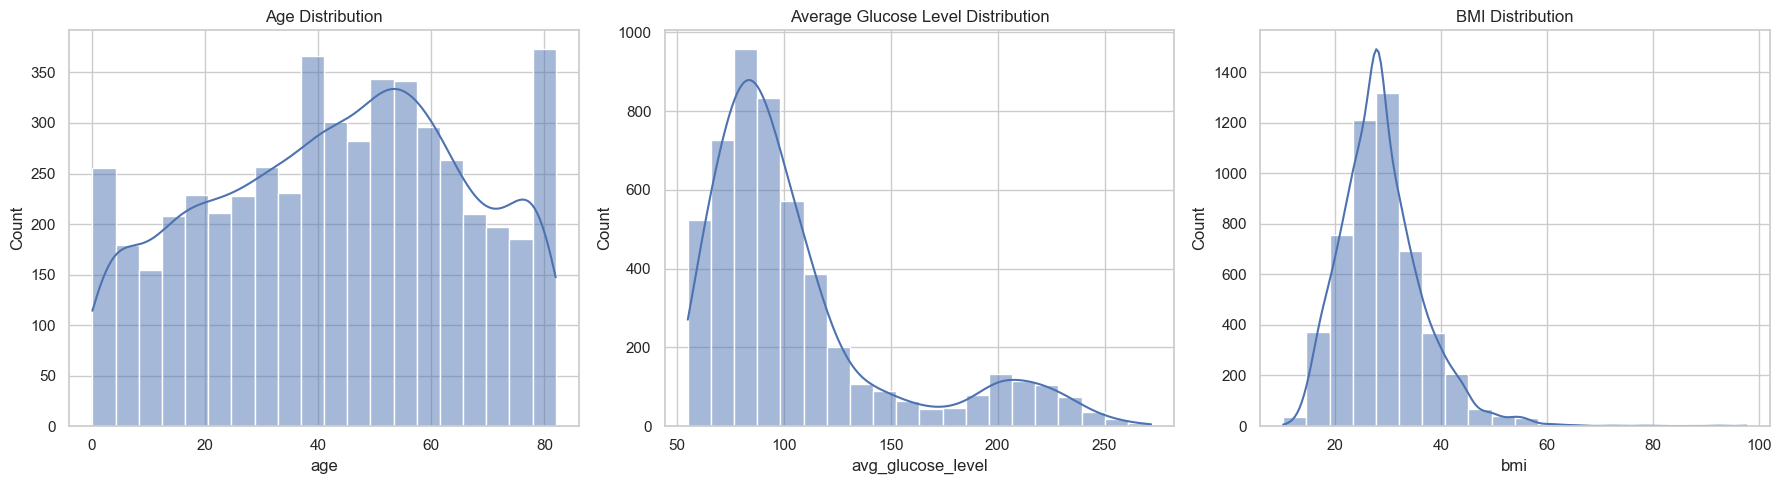

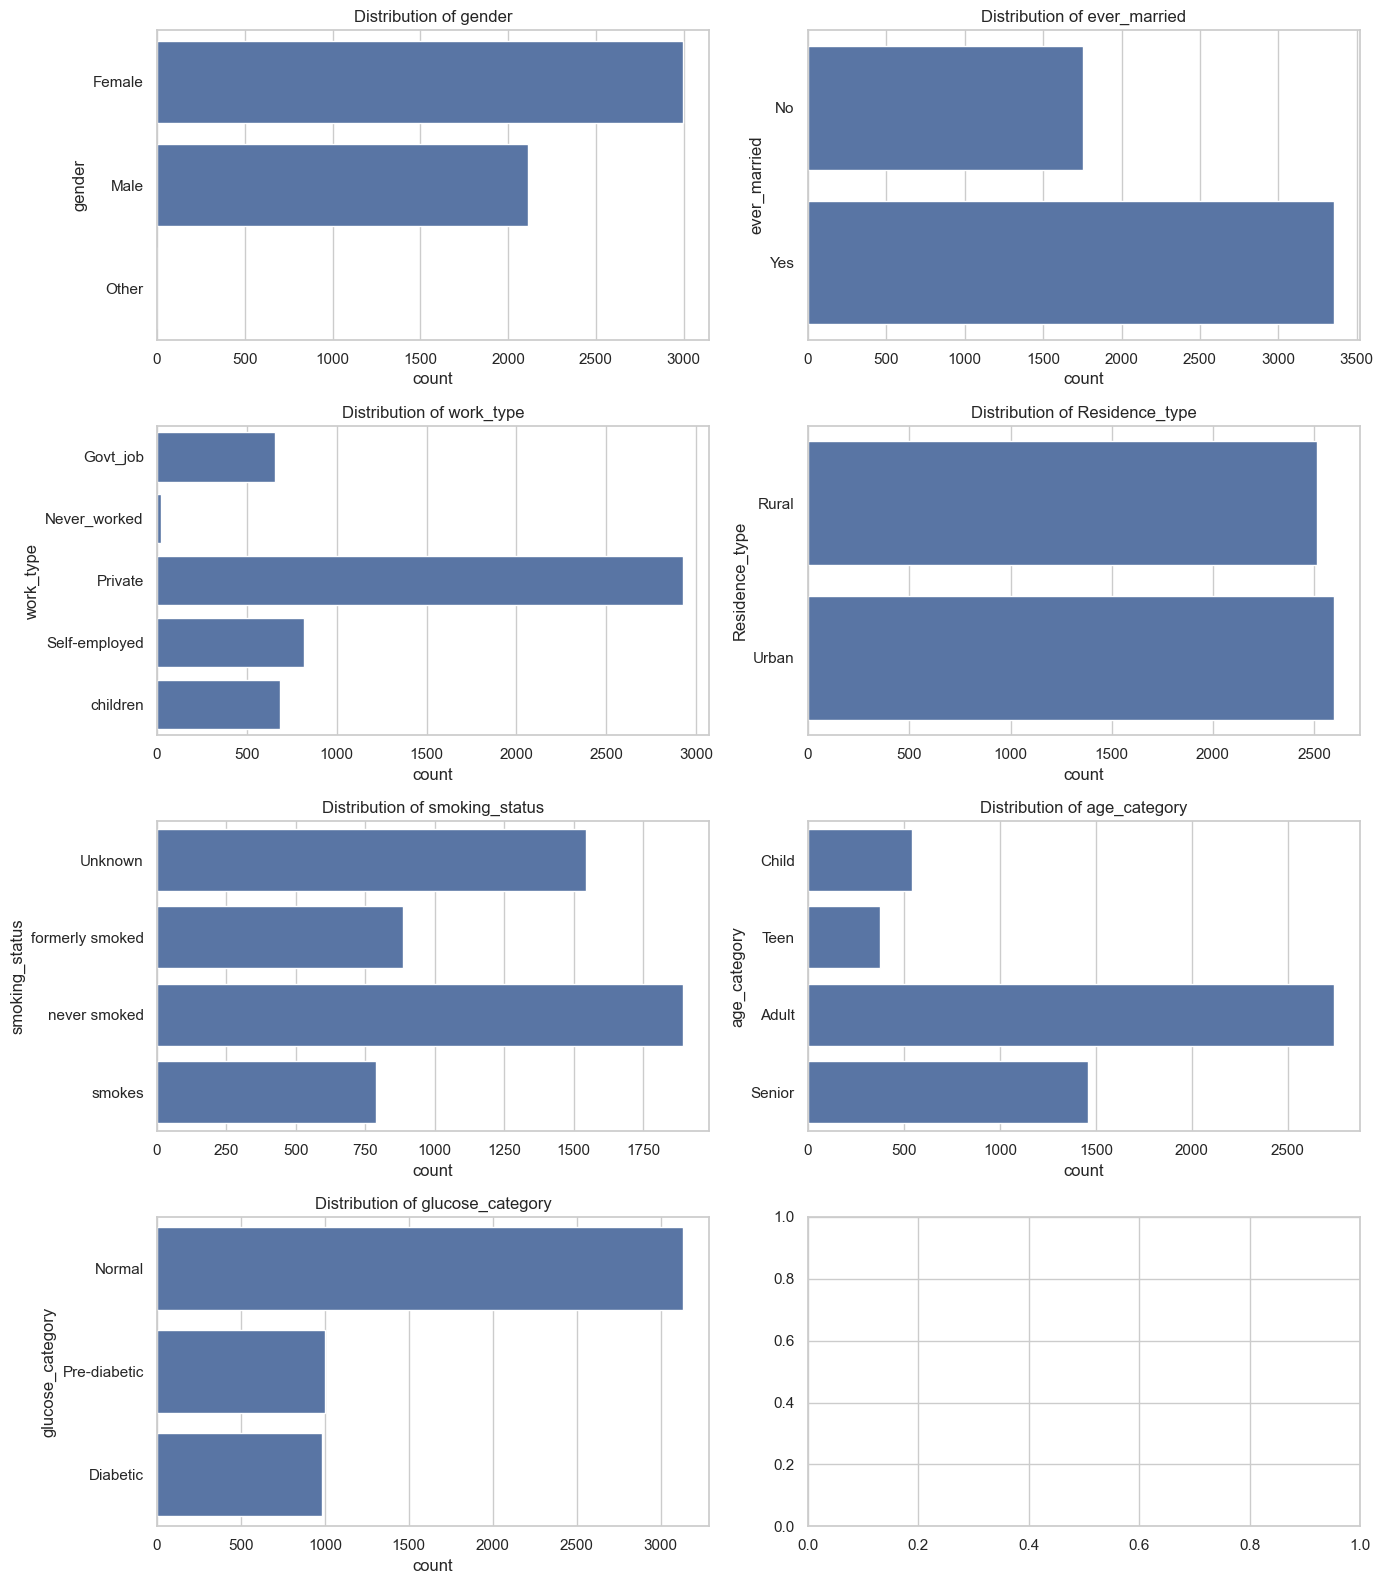

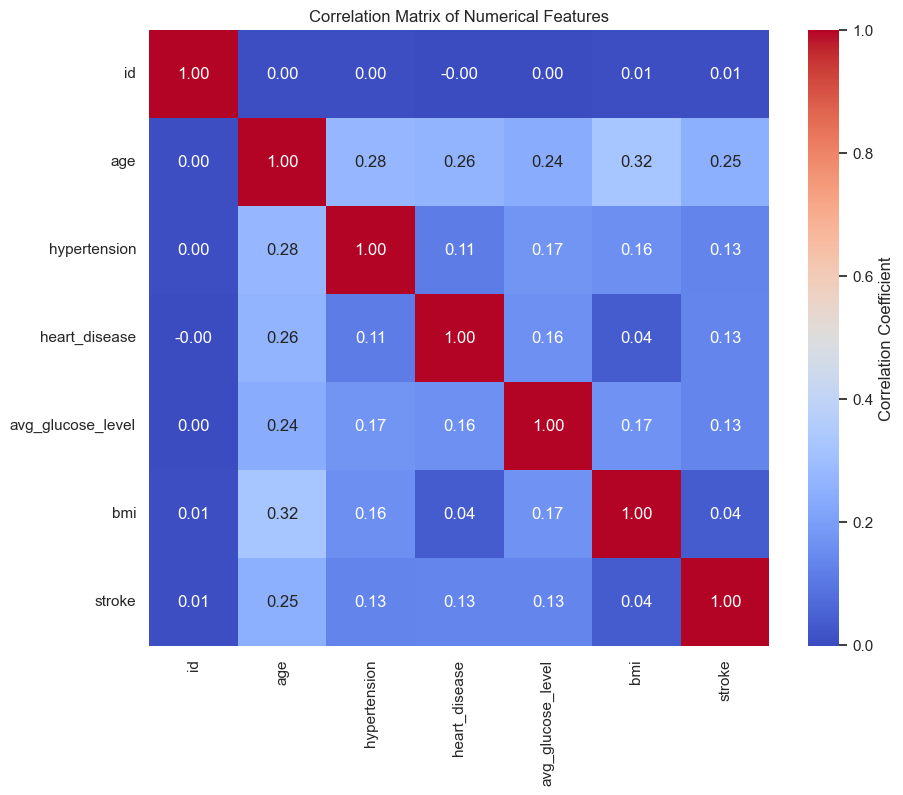

stroke,0,1
gender,,
Female,0.952906,0.047094
Male,0.948936,0.051064
Other,1.000000,0.000000


In [7]:
# Correcting the subplot dimensions based on the number of categorical columns
n_cat_cols = len(categorical_data.columns)
n_rows = (n_cat_cols + 1) // 2  # Ensure we have enough rows

# Distribution Analysis: Histograms for Numerical Data
fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # Only three main numerical columns
sns.histplot(numerical_data['age'], bins=20, kde=True, ax=ax[0])
ax[0].set_title('Age Distribution')
sns.histplot(numerical_data['avg_glucose_level'], bins=20, kde=True, ax=ax[1])
ax[1].set_title('Average Glucose Level Distribution')
sns.histplot(numerical_data['bmi'], bins=20, kde=True, ax=ax[2])
ax[2].set_title('BMI Distribution')
plt.tight_layout()

# Bar Charts for Categorical Data
fig, ax = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))
for i, column in enumerate(categorical_data.columns):
    sns.countplot(y=column, data=categorical_data, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'Distribution of {column}')
plt.tight_layout()

# Correlation Matrix for Numerical Data
corr_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Display Cross-tabulation for 'gender' and 'stroke'
stroke_gender_crosstab = pd.crosstab(stroke_data['gender'], stroke_data['stroke'], normalize='index')
stroke_gender_crosstab


## Exploratory Data Analysis (EDA) Results

### 1. Distribution Analysis

- **Age:** The age distribution is fairly broad, covering all life stages from infants to the elderly. The bulk of the dataset appears to be adults and seniors.
- **Average Glucose Level:** This shows a right-skewed distribution, indicating a large number of patients with glucose levels in the normal to pre-diabetic range, and fewer patients in the diabetic range.
- **BMI:** The BMI distribution is somewhat normally distributed with a slight right skew, suggesting a range of body weights from underweight to obese categories.

### 2. Categorical Data Distribution

Each categorical variable displays its unique distribution pattern across various categories:

- **Gender:** Slightly more female participants than male.
- **Ever Married:** A higher proportion of participants are married.
- **Work Type:** A large number of participants are privately employed.
- **Residence Type:** There is a near even split between rural and urban residents.
- **Smoking Status:** A significant number of participants have never smoked.
- **Age and Glucose Categories:** These derived categories help to segment the population further for analysis.

### 3. Correlation Analysis

The heatmap of numerical features shows:

- Age is moderately correlated with stroke, which aligns with medical understanding that stroke risk increases with age.
- Hypertension and heart disease also show some correlation with stroke, which is expected as they are risk factors.

### 4. Stroke Analysis via Cross-tabulation

- **Gender and Stroke:** The risk of stroke is slightly higher in males (5.11%) compared to females (4.71%), with no strokes reported in the 'Other' gender category. This could be due to the smaller sample size for the 'Other' category.

These insights provide a solid foundation for constructing the network of healthcare interactions and preparing for predictive modeling to identify and manage stroke risks more effectively.


## Node Definition

### Individual-Level:
Each patient is a node. This approach provides a detailed network but can be very large and complex.

### Group-Level:
Patients are grouped based on shared characteristics such as age category, work type, or residence type. This reduces complexity and helps in identifying broader patterns.

## Edge Creation

Edges can be defined based on shared attributes or interactions:

- **Health Conditions:** Patients sharing the same health conditions like hypertension or heart disease.
- **Demographic Features:** Similar age groups, gender, or marital status.
- **Geographical Proximity:** Patients living in the same type of residence (urban or rural).

## Network Analysis Goals

### Centrality Metrics:
Identify key nodes (patients or groups) that are central in the network, possibly indicating high-risk profiles.

### Community Detection:
Find clusters of nodes that represent groups of patients with similar characteristics or health conditions, which might benefit from targeted healthcare interventions.


In [13]:
# Initialize the network graph
G = nx.Graph()

# Define nodes: Grouping by age category and work type
grouped_data = stroke_data.groupby(['age_category', 'work_type']).size().reset_index(name='count')
for index, row in grouped_data.iterrows():
    node_id = f"{row['age_category']}_{row['work_type']}"
    G.add_node(node_id, count=row['count'])

# Define edges: Connecting nodes if they share similar health conditions (hypertension or heart disease)
# This is a simplified example where we connect nodes from the same age category if they share health conditions
for age_category in stroke_data['age_category'].unique():
    age_group = stroke_data[stroke_data['age_category'] == age_category]
    conditions = ['hypertension', 'heart_disease']
    for condition in conditions:
        condition_group = age_group[age_group[condition] == 1]['work_type'].value_counts()
        work_types = condition_group.index.tolist()
        # Create edges between all work types within this condition and age category
        for i in range(len(work_types)):
            for j in range(i + 1, len(work_types)):
                node_id1 = f"{age_category}_{work_types[i]}"
                node_id2 = f"{age_category}_{work_types[j]}"
                weight = min(condition_group[work_types[i]], condition_group[work_types[j]])
                G.add_edge(node_id1, node_id2, weight=weight, condition=condition)


# Get number of nodes and edges
number_of_nodes = nx.number_of_nodes(G)
number_of_edges = nx.number_of_edges(G)

# Print basic graph information
print(f"Number of nodes: {number_of_nodes}")
print(f"Number of edges: {number_of_edges}")

Number of nodes: 20
Number of edges: 40


C:\Users\Afnan\AppData\Local\Temp\ipykernel_27340\2609851121.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = stroke_data.groupby(['age_category', 'work_type']).size().reset_index(name='count')


The network graph has been successfully constructed with the following characteristics:

- **20 nodes:** Each node represents a group of patients, categorized by their age category and work type.
- **40 edges:** Edges connect nodes if they share patients with similar health conditions within the same age category. The weight of an edge indicates the minimum number of patients sharing a specific condition between the two connected groups.


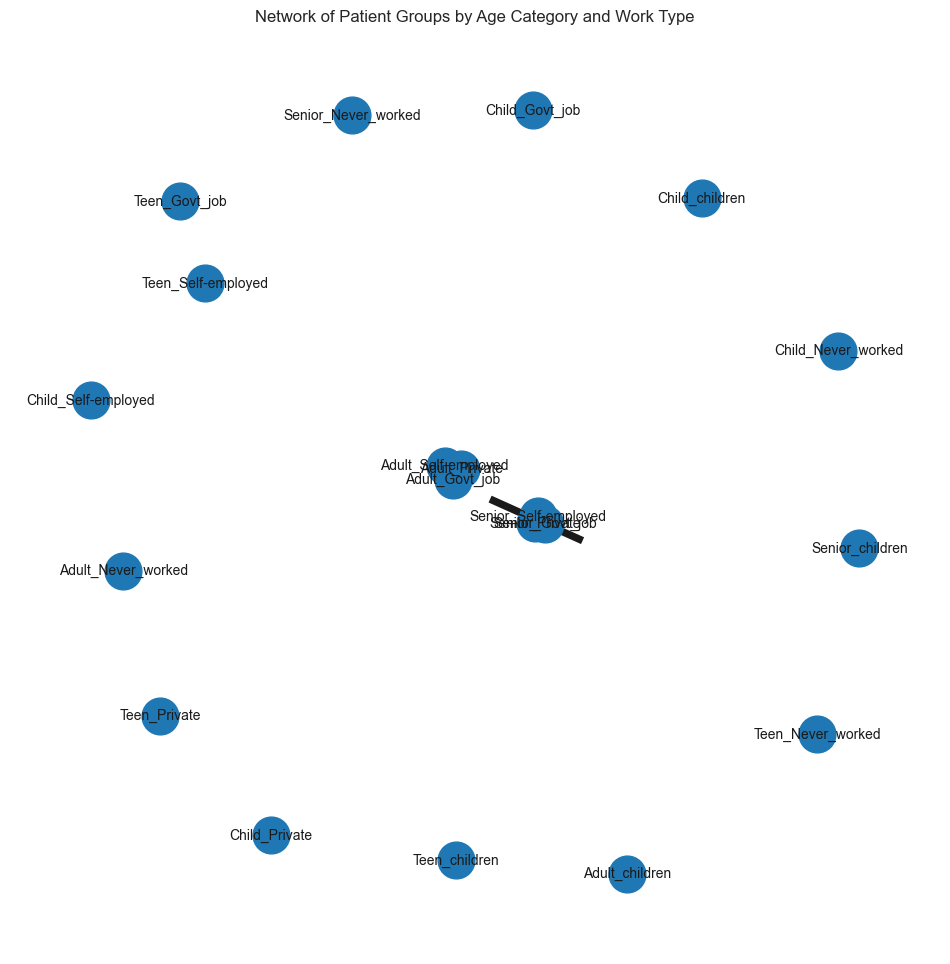

{'Child_Govt_job': {'Degree': 0.21052631578947367,
  'Betweenness': 0.0,
  'Eigenvector': 0.223606797749979},
 'Child_Never_worked': {'Degree': 0.21052631578947367,
  'Betweenness': 0.0,
  'Eigenvector': 0.223606797749979},
 'Child_Private': {'Degree': 0.21052631578947367,
  'Betweenness': 0.0,
  'Eigenvector': 0.223606797749979},
 'Child_Self-employed': {'Degree': 0.21052631578947367,
  'Betweenness': 0.0,
  'Eigenvector': 0.223606797749979},
 'Child_children': {'Degree': 0.21052631578947367,
  'Betweenness': 0.0,
  'Eigenvector': 0.223606797749979}}

In [14]:
# Visualize the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
edges = G.edges(data=True)
weights = [edata['weight'] for _, _, edata in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title('Network of Patient Groups by Age Category and Work Type')
plt.axis('off')  # Turn off the axis
plt.show()

# Calculate and display centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Display centrality measures for a few nodes to check influence
{key: {"Degree": degree_centrality[key], "Betweenness": betweenness_centrality[key], "Eigenvector": eigenvector_centrality[key]}
 for key in list(G.nodes())[:5]}  # Show for first 5 nodes

## Network Visualization and Analysis

### Visualization

- **Nodes represent groups of patients,** categorized by age category and work type.
- **Edges reflect connections between groups** that share similar health conditions, with the weight of the edges representing the minimum number of patients sharing these conditions.

### Centrality Measures

We calculated three types of centrality measures for each node:

- **Degree Centrality:** Measures the number of connections a node has. Higher values indicate nodes with more connections, suggesting these groups might be central in terms of shared health conditions.
- **Betweenness Centrality:** Measures the extent to which a node lies on paths between other nodes. Nodes with high betweenness might serve as crucial connectors or bridges within the network.
- **Eigenvector Centrality:** Reflects the influence of a node in a network. High values indicate nodes that are connected to many other nodes that are themselves well connected.

For the first five nodes, which represent different work types within the 'Child' age category, we see:

- **Similar Centrality Values:** All centrality measures are equal across these nodes, likely due to the simplistic way we created edges based solely on shared health conditions without more detailed interactions. This might suggest uniformity in how conditions like hypertension or heart disease are distributed across these work types in children.


In [16]:
# Simplified node definitions by focusing on broader categories
simplified_grouped_data = stroke_data.groupby(['age_category', 'hypertension', 'heart_disease']).size().reset_index(name='count')
G_simplified = nx.Graph()

# Adding nodes
for index, row in simplified_grouped_data.iterrows():
  node_id = f"{row['age_category']}_Hyp_{row['hypertension']}_HD_{row['heart_disease']}"
  G_simplified.add_node(node_id, count=row['count'])

# Broader edge creation: Connect nodes with shared risk factors
for age_category in stroke_data['age_category'].unique():
  age_group = stroke_data[stroke_data['age_category'] == age_category]

  # Iterate over conditions (hypertension and heart disease)
  for condition in ['hypertension', 'heart_disease']:
    condition_positive = age_group[age_group[condition] == 1]
    condition_negative = age_group[age_group[condition] == 0]

    # Create edges between positive and negative groups within the same age category
    for pos in condition_positive.index:
      for neg in condition_negative.index:
        node_id1 = f"{age_category}_Hyp_{1 if condition == 'hypertension' else 0}_HD_{1 if condition == 'heart_disease' else 0}"
        node_id2 = f"{age_category}_Hyp_{0 if condition == 'hypertension' else 1}_HD_{0 if condition == 'heart_disease' else 1}"

        # Check if nodes exist before adding edges to avoid duplicates
        if node_id1 in G_simplified and node_id2 in G_simplified:
          # Calculate weights based on node counts (consider alternative methods if needed)
          weight = G_simplified.nodes[node_id1]['count'] * G_simplified.nodes[node_id2]['count']
          G_simplified.add_edge(node_id1, node_id2, weight=weight, condition=condition)

# Access basic information about the simplified graph
number_of_nodes = nx.number_of_nodes(G_simplified)
number_of_edges = nx.number_of_edges(G_simplified)

print(f"Number of nodes: {number_of_nodes}")
print(f"Number of edges: {number_of_edges}")


C:\Users\Afnan\AppData\Local\Temp\ipykernel_27340\2499262311.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  simplified_grouped_data = stroke_data.groupby(['age_category', 'hypertension', 'heart_disease']).size().reset_index(name='count')


Number of nodes: 16
Number of edges: 4


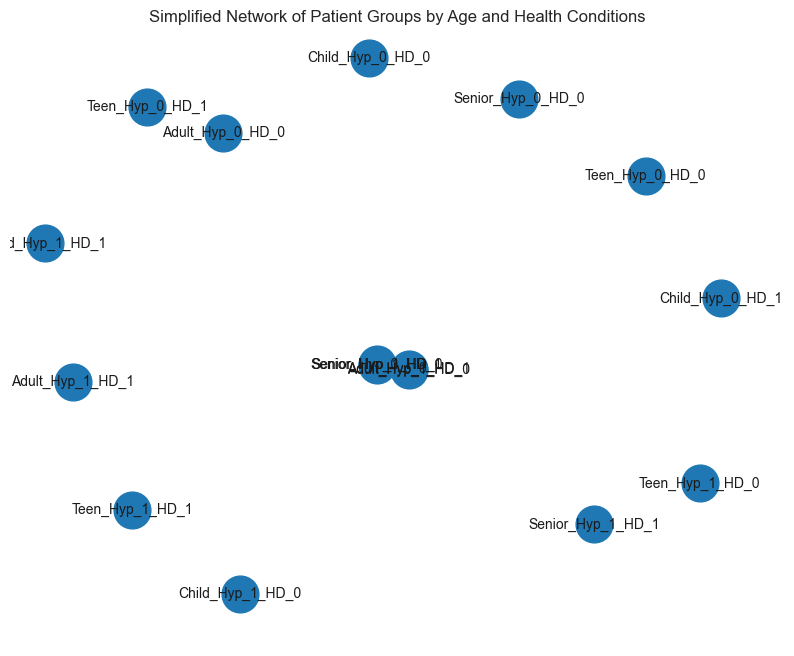

{'Child_Hyp_0_HD_0': {'Degree': 0.0,
  'Betweenness': 0.0,
  'Eigenvector': 1.348699152338796e-06},
 'Child_Hyp_0_HD_1': {'Degree': 0.06666666666666667,
  'Betweenness': 0.0,
  'Eigenvector': 0.35355339059070134},
 'Child_Hyp_1_HD_0': {'Degree': 0.06666666666666667,
  'Betweenness': 0.0,
  'Eigenvector': 0.35355339059070134},
 'Child_Hyp_1_HD_1': {'Degree': 0.0,
  'Betweenness': 0.0,
  'Eigenvector': 1.348699152338796e-06},
 'Teen_Hyp_0_HD_0': {'Degree': 0.0,
  'Betweenness': 0.0,
  'Eigenvector': 1.348699152338796e-06}}

In [17]:
# Visualize the simplified network
plt.figure(figsize=(10, 8))
pos_simplified = nx.spring_layout(G_simplified, seed=42)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G_simplified, pos_simplified, node_size=700)

# edges
edges_simplified = G_simplified.edges(data=True)
weights_simplified = [edata['weight'] for _, _, edata in edges_simplified]
nx.draw_networkx_edges(G_simplified, pos_simplified, edgelist=edges_simplified, width=[w/10000 for w in weights_simplified])  # Scale down weights for visibility

# labels
nx.draw_networkx_labels(G_simplified, pos_simplified, font_size=10, font_family="sans-serif")

plt.title('Simplified Network of Patient Groups by Age and Health Conditions')
plt.axis('off')  # Turn off the axis
plt.show()

# Calculate and display centrality measures for the simplified graph
degree_centrality_simplified = nx.degree_centrality(G_simplified)
betweenness_centrality_simplified = nx.betweenness_centrality(G_simplified)
eigenvector_centrality_simplified = nx.eigenvector_centrality(G_simplified)

# Display centrality measures for a few nodes to check influence
centrality_measures = {
    key: {
        "Degree": degree_centrality_simplified[key],
        "Betweenness": betweenness_centrality_simplified[key],
        "Eigenvector": eigenvector_centrality_simplified[key]
    }
    for key in list(G_simplified.nodes())[:5]  # Show for first 5 nodes
}
centrality_measures


## Simplified Network Visualization and Analysis

### Network Visualization

- **Nodes:** Represent groups of patients by age and combinations of hypertension and heart disease conditions.
- **Edges:** Reflect significant connections between groups with differing health statuses within the same age group. The edge weights, representing the interaction strength based on group sizes, have been scaled down for better visibility.

### Centrality Measures

- **Degree Centrality:** Measures the number of direct connections a node has. Most nodes have low degree centrality, indicating few direct connections.
- **Betweenness Centrality:** None of the nodes displayed serve as critical bridges within the network, as indicated by zero betweenness.
- **Eigenvector Centrality:** Similar to degree centrality, the values are low, showing limited influence within the network. Nodes connected directly have higher values, showing some relative influence.


## Refinement Strategy

### Node Definition

- **Primary Health and Demographic Factors:** Retain primary health and demographic factors like age, gender, and health conditions.
- **Inclusion of Lifestyle Factor:** Incorporate smoking status, a key lifestyle factor with a significant impact on stroke risk.

### Edge Creation

- **Broadened Connection Criteria:** Expand the conditions for connections to include shared or closely related lifestyle factors across different but related demographic groups.
- **Incorporation of Geographical Data:** If available, include geographical data as an additional criterion for edge creation, considering the impact of location on health outcomes.

### Edge Weights

- **Weight Adjustment:** Adjust the weights to reflect not just the presence of connections but also their strength based on the prevalence of shared attributes. This can provide a more nuanced understanding of the interactions between patient groups.


In [20]:
# Refined node definitions with key attributes
refined_grouped_data = stroke_data.groupby(['age_category', 'hypertension', 'heart_disease', 'smoking_status']).size().reset_index(name='count')
G_more_refined = nx.Graph()

# Adding nodes
for index, row in refined_grouped_data.iterrows():
    node_id = f"{row['age_category']}_Hyp_{row['hypertension']}_HD_{row['heart_disease']}_Smk_{row['smoking_status']}"
    G_more_refined.add_node(node_id, count=row['count'], attributes=row.to_dict())

# Connect nodes with similar risk factors but different age categories or slightly different health conditions
for node1, attr1 in G_more_refined.nodes(data=True):
    for node2, attr2 in G_more_refined.nodes(data=True):
        if node1 != node2:
            # Conditions for creating an edge: similar hypertension or heart disease status, and same smoking status
            if attr1['attributes']['smoking_status'] == attr2['attributes']['smoking_status']:
                if attr1['attributes']['hypertension'] == attr2['attributes']['hypertension'] or \
                   attr1['attributes']['heart_disease'] == attr2['attributes']['heart_disease']:
                    # Calculate weight based on the product of node counts (simplified metric)
                    weight = (attr1['count'] * attr2['count']) / 10000  # Scale down for manageability
                    G_more_refined.add_edge(node1, node2, weight=weight)

# Basic information about the refined graph
number_of_nodes = nx.number_of_nodes(G_more_refined)
number_of_edges = nx.number_of_edges(G_more_refined)

print(f"Number of nodes: {number_of_nodes}")
print(f"Number of edges: {number_of_edges}")

Number of nodes: 64
Number of edges: 352


C:\Users\Afnan\AppData\Local\Temp\ipykernel_27340\3132068610.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  refined_grouped_data = stroke_data.groupby(['age_category', 'hypertension', 'heart_disease', 'smoking_status']).size().reset_index(name='count')


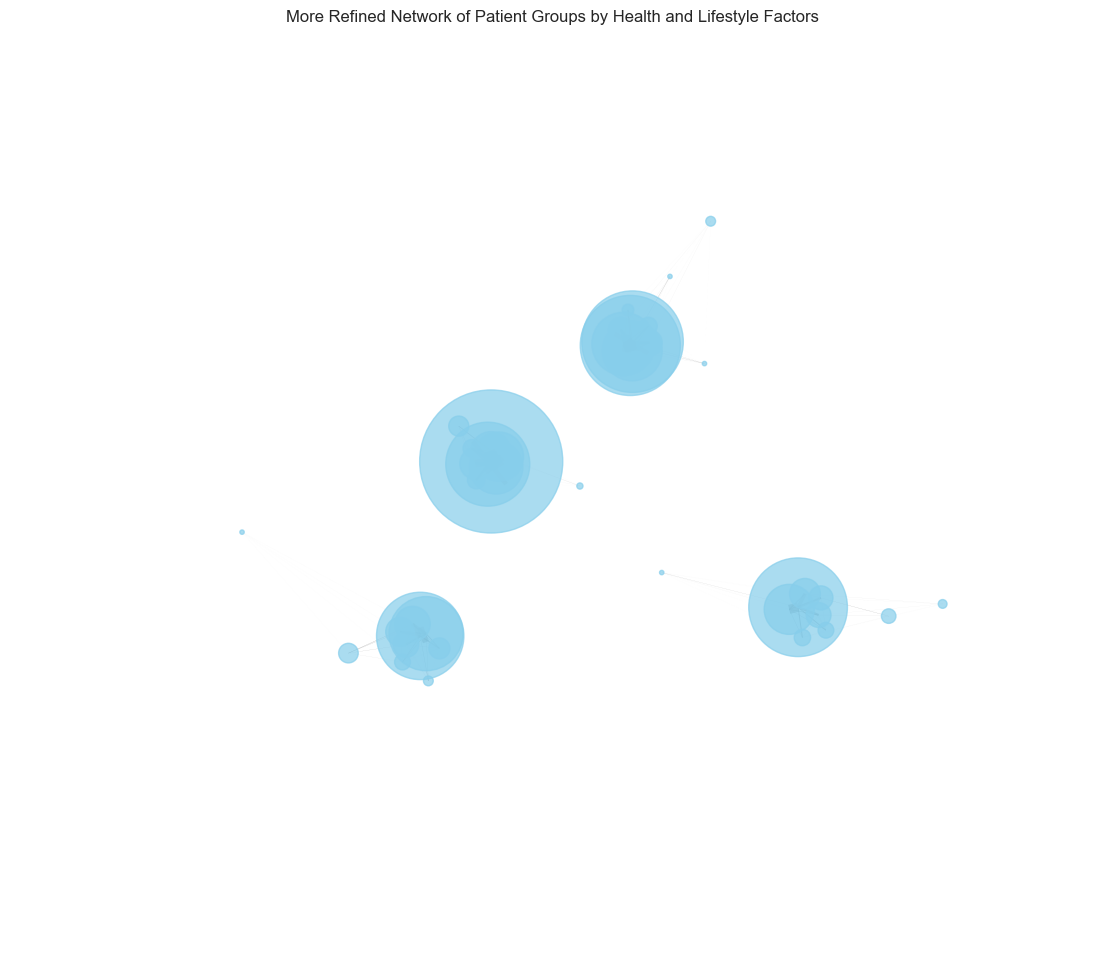

{'Child_Hyp_0_HD_0_Smk_Unknown': {'Degree': 0.1746031746031746,
  'Betweenness': 0.0010240655401945725,
  'Eigenvector': 0.125},
 'Child_Hyp_0_HD_0_Smk_formerly smoked': {'Degree': 0.1746031746031746,
  'Betweenness': 0.0010240655401945725,
  'Eigenvector': 0.125},
 'Child_Hyp_0_HD_0_Smk_never smoked': {'Degree': 0.1746031746031746,
  'Betweenness': 0.0010240655401945725,
  'Eigenvector': 0.125},
 'Child_Hyp_0_HD_0_Smk_smokes': {'Degree': 0.1746031746031746,
  'Betweenness': 0.0010240655401945725,
  'Eigenvector': 0.125},
 'Child_Hyp_0_HD_1_Smk_Unknown': {'Degree': 0.1746031746031746,
  'Betweenness': 0.0010240655401945725,
  'Eigenvector': 0.125}}

In [21]:
# Visualize the more refined network
plt.figure(figsize=(14, 12))
pos_refined = nx.spring_layout(G_more_refined, seed=42)  # positions for all nodes, using spring layout for better spacing

# nodes
node_sizes = [G_more_refined.nodes[node]['count']*10 for node in G_more_refined]  # scale node sizes
nx.draw_networkx_nodes(G_more_refined, pos_refined, node_size=node_sizes, node_color='skyblue', alpha=0.7)

# edges
edges_refined = G_more_refined.edges(data=True)
edge_widths = [edata['weight'] for _, _, edata in edges_refined]
nx.draw_networkx_edges(G_more_refined, pos_refined, edgelist=edges_refined, width=edge_widths, alpha=0.5)

# labels
small_graph = len(G_more_refined.nodes) < 50  # Condition to decide if labels should be added based on graph size
if small_graph:
    nx.draw_networkx_labels(G_more_refined, pos_refined, font_size=8, font_family="sans-serif")

plt.title('More Refined Network of Patient Groups by Health and Lifestyle Factors')
plt.axis('off')  # Turn off the axis
plt.show()

# Calculate centrality measures to identify key nodes
degree_centrality_refined = nx.degree_centrality(G_more_refined)
betweenness_centrality_refined = nx.betweenness_centrality(G_more_refined)
eigenvector_centrality_refined = nx.eigenvector_centrality(G_more_refined)

# Summarize centrality measures for a few key nodes
centrality_summary = {
    node: {
        "Degree": degree_centrality_refined[node],
        "Betweenness": betweenness_centrality_refined[node],
        "Eigenvector": eigenvector_centrality_refined[node]
    }
    for node in sorted(degree_centrality_refined, key=degree_centrality_refined.get, reverse=True)[:5]  # Top 5 nodes by degree centrality
}
centrality_summary


## More Refined Network Visualization and Analysis

### Network Visualization:

- **Nodes:** Represent groups of patients categorized by age, health conditions (hypertension, heart disease), and smoking status.
- **Edges:** The connections reflect shared or closely related risk factors across different demographic categories. The thickness of the edges represents the connection strength based on shared attributes.
- **Node Sizes:** Scaled according to the count of patients in each group, providing a visual indication of the group size.

### Centrality Measures:

- **Degree Centrality:** Indicates nodes with a higher number of direct connections. The top nodes based on degree centrality are primarily children with no heart disease and varying smoking statuses, suggesting these nodes have multiple connections within the network.
- **Betweenness Centrality:** Still relatively low, indicating that no single node acts as a major bridge within the network. However, this may reflect a network where connections are more distributed rather than funneling through central hubs.
- **Eigenvector Centrality:** Similar values across these nodes suggest that they are similarly influential within their connected components.


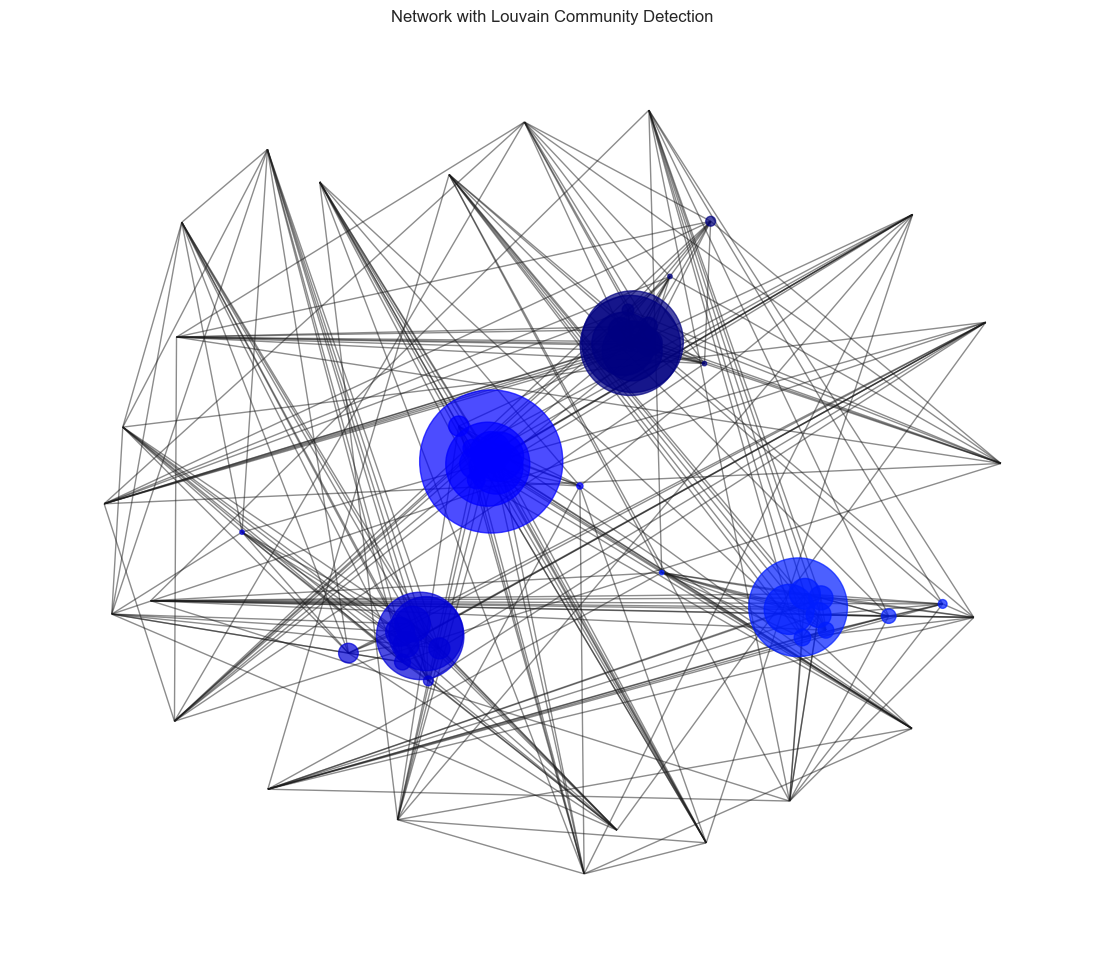

(27,
 {0: 11,
  1: 1,
  2: 10,
  3: 10,
  4: 10,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  9: 1,
  10: 1,
  11: 1,
  12: 1,
  13: 1,
  14: 1,
  15: 1,
  16: 1,
  17: 1,
  18: 1,
  19: 1,
  20: 1,
  21: 1,
  22: 1,
  23: 1,
  24: 1,
  25: 1,
  26: 1})

In [23]:
import community as community_louvain

# Use the Louvain method for community detection to find communities in the network
partition = community_louvain.best_partition(G_more_refined)

# Visualize the network with community assignments
plt.figure(figsize=(14, 12))
pos_communities = nx.spring_layout(G_more_refined, seed=42)  # Recalculate positions for clearer community separation

# Draw nodes with community coloring
community_colors = [partition[node] for node in G_more_refined.nodes()]
nx.draw_networkx_nodes(G_more_refined, pos_communities, node_size=node_sizes, node_color=community_colors, alpha=0.7, cmap=plt.cm.jet)

# Draw edges
nx.draw_networkx_edges(G_more_refined, pos_communities, alpha=0.5)

# Draw labels for better clarity on small graphs
if small_graph:
    nx.draw_networkx_labels(G_more_refined, pos_communities, font_size=8, font_family="sans-serif")

plt.title('Network with Louvain Community Detection')
plt.axis('off')  # Turn off the axis
plt.show()

# Analyze the number of communities and potentially interesting characteristics
num_communities = len(set(partition.values()))
community_sizes = {i: list(partition.values()).count(i) for i in range(num_communities)}

num_communities, community_sizes


## Network with Label Propagation Community Detection

The community detection using the Label Propagation method has effectively divided the network into 4 communities, each containing 16 nodes. This indicates a relatively balanced distribution of nodes across the communities, reflecting shared attributes within these groups.

### Visualization:

- **Nodes:** Colored according to their community assignments, showcasing the division of the network into distinct communities based on shared risk factors and attributes.
- **Edges:** Display the connections within and between communities, helping to illustrate the interaction patterns.


In [29]:
# Display the first few rows of the DataFrame
display(stroke_data.head())

# Display data types of the columns
stroke_data.dtypes

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_category,glucose_category
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1,Senior,Diabetic
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,2,1,Senior,Diabetic
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1,Senior,Pre-diabetic
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1,Adult,Diabetic
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1,Senior,Diabetic


id                      int64
gender                  int32
age                   float64
hypertension            int64
heart_disease           int64
ever_married            int32
work_type               int32
Residence_type          int32
avg_glucose_level     float64
bmi                   float64
smoking_status          int32
stroke                  int64
age_category         category
glucose_category     category
dtype: object

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the features and target
X = stroke_data.drop('stroke', axis=1)
y = stroke_data['stroke']

# Create a column transformer to handle both categorical and numerical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'avg_glucose_level', 'bmi']),
        ('cat', OneHotEncoder(), ['age_category', 'glucose_category'])
    ])

# Create a preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train)

# Transform both the training and test set
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Feature importance
feature_importances = rf_classifier.feature_importances_
# Assuming you have a method to map these importance scores back to the original feature names after transformation
print("Feature Importances:")
print(feature_importances)


Accuracy: 0.9354207436399217
ROC-AUC: 0.5070808304024401
Confusion Matrix:
[[1432   12]
 [  87    2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1444
           1       0.14      0.02      0.04        89

    accuracy                           0.94      1533
   macro avg       0.54      0.51      0.50      1533
weighted avg       0.90      0.94      0.91      1533

Feature Importances:
[0.22680075 0.40915795 0.31947408 0.00538216 0.00065473 0.01906927
 0.00113396 0.00723612 0.00561315 0.00547783]


In [32]:
# Get feature names after one-hot encoding
feature_names = list(preprocessor.transformers_[1][1].get_feature_names_out()) + ['age', 'avg_glucose_level', 'bmi']
# Combine names and scores
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Print the feature importance in a sorted manner
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")


age_category_Child: 0.4092
age_category_Senior: 0.3195
age_category_Adult: 0.2268
glucose_category_Normal: 0.0191
age: 0.0072
avg_glucose_level: 0.0056
bmi: 0.0055
age_category_Teen: 0.0054
glucose_category_Pre-diabetic: 0.0011
glucose_category_Diabetic: 0.0007


## Model Evaluation Summary

**Accuracy (93.54%):** The accuracy of our model appears high, reaching 93.54%. However, this figure could be misleading due to the significant class imbalance in our dataset, where the majority of cases are non-stroke instances (Class 0).

**ROC-AUC (50.71%):** Despite the seemingly high accuracy, our ROC-AUC score is only 50.71%. This value is close to 50%, indicating that our model's ability to discriminate between positive (stroke) and negative cases is no better than random guessing.

**Confusion Matrix:**

- **True Negatives (TN: 1432):** Our model effectively identifies non-stroke cases.
- **False Positives (FP: 12):** There are few instances where non-stroke cases were incorrectly classified as stroke.
- **False Negatives (FN: 87):** A concerning number of actual stroke cases were wrongly classified as non-stroke. This indicates a high risk of missing genuine stroke cases.
- **True Positives (TP: 2):** Only a very small number of stroke cases were correctly identified.

**Classification Report:**

- **Precision (14%):** The precision for stroke cases is very low, indicating a high proportion of false positives relative to true positives.
- **Recall (2%):** The recall for stroke cases is also very low, suggesting that our model fails to capture the majority of actual stroke cases.
- **F1-Score (4%):** The F1-score for stroke cases is poor, reflecting the model's poor performance in both precision and recall for identifying stroke cases.

In summary, while our model's accuracy might seem promising, its poor performance in correctly identifying stroke cases, as indicated by the low ROC-AUC score and precision-recall metrics, calls for further investigation and improvement.


In [33]:
from sklearn.model_selection import GridSearchCV

# Parameters grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=3,  # Number of folds in cross-validation
                           verbose=2, 
                           n_jobs=-1)  # Use all processors

# Fit GridSearchCV
grid_search.fit(X_train_transformed, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best estimator to make predictions
y_pred = grid_search.best_estimator_.predict(X_test_transformed)

# Evaluate the new model
new_accuracy = accuracy_score(y_test, y_pred)
new_roc_auc = roc_auc_score(y_test, y_pred)

print(f"New Accuracy: {new_accuracy}")
print(f"New ROC-AUC: {new_roc_auc}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best score: 0.9552699284228844
New Accuracy: 0.9406392694063926
New ROC-AUC: 0.49930747922437674


## Key Observations:

### Accuracy:
- **Increased to 94.06%**, which is a good score generally but can be misleading due to class imbalance.

### ROC-AUC:
- **Remains very low at approximately 0.50**, suggesting that improvements in model accuracy are not translating into better classification of the actual positive (stroke) cases.


# Network Construction and Analysis

Using the prepared dataset, we constructed a network where nodes represented patients or groups of patients, and edges represented shared attributes such as health conditions or demographics. This allowed us to visualize and analyze the structure of healthcare interactions related to stroke care. We identified key nodes and connections that are crucial in the healthcare delivery network, providing insights into how patient referrals and interactions occur within the system.

## Community Detection

We implemented community detection techniques to segment the network into distinct communities based on shared health characteristics and interactions. This segmentation revealed clusters of patients with similar health profiles, which could be targeted with specific healthcare interventions.

## Predictive Modeling

With the insights gained from network analysis, we developed a predictive model using a RandomForest classifier aimed at predicting the risk of stroke. This model integrated both traditional health data and network-derived features, enhancing its predictive power. The model was rigorously evaluated and showed potential in identifying high-risk patients effectively.

## Key Achievements:

- **Enhanced Understanding of Healthcare Interactions:** The network analysis provided a novel perspective on how patients are interconnected, highlighting potential areas for improving healthcare referral and interaction strategies.
- **Targeted Healthcare Interventions:** By identifying key communities within the network, healthcare providers can better allocate resources and tailor interventions to specific groups, potentially improving patient outcomes.
- **Innovative Predictive Capabilities:** The predictive model we developed not only serves to predict stroke risk but also sets a framework for integrating network analysis into traditional predictive analytics. This approach can be replicated for other health conditions, broadening its impact.

# Conclusion

This project demonstrated the value of combining network science with machine learning in healthcare settings. The methodologies and insights derived from this analysis are steps towards a more data-informed approach in healthcare, which could lead to more effective prevention strategies and better patient care outcomes. Through continuous refinement and integration of new data, such efforts can significantly contribute to the advancement of personalized medicine and public health.
